In [1]:
## Importing Libraries
import os
import gc
import csv
import math
import glob
import lorem
import random
import lxml
import pandas as pd
import numpy as np
import warnings
from sklearn.model_selection import train_test_split

from collections import defaultdict
from IPython.display import display, HTML, Image

# ignore all warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_colwidth', None)


### This Notebook delivers the initialization stages of generating and transforming the DBLP dataset suitable for import into Neo4j. It contains pre-processing necessary for both the initial and evolved graph models.

### A2 Instantiating

#### Generating DBLP files

In [2]:
#All CSV files generated from the DBLP XML

## All files and directories ending with .csv:
files = (glob.glob("DXML/*.csv"))
files[0:5]

['DXML\\output_article.csv',
 'DXML\\output_article_header.csv',
 'DXML\\output_author.csv',
 'DXML\\output_author_authored_by.csv',
 'DXML\\output_book.csv']

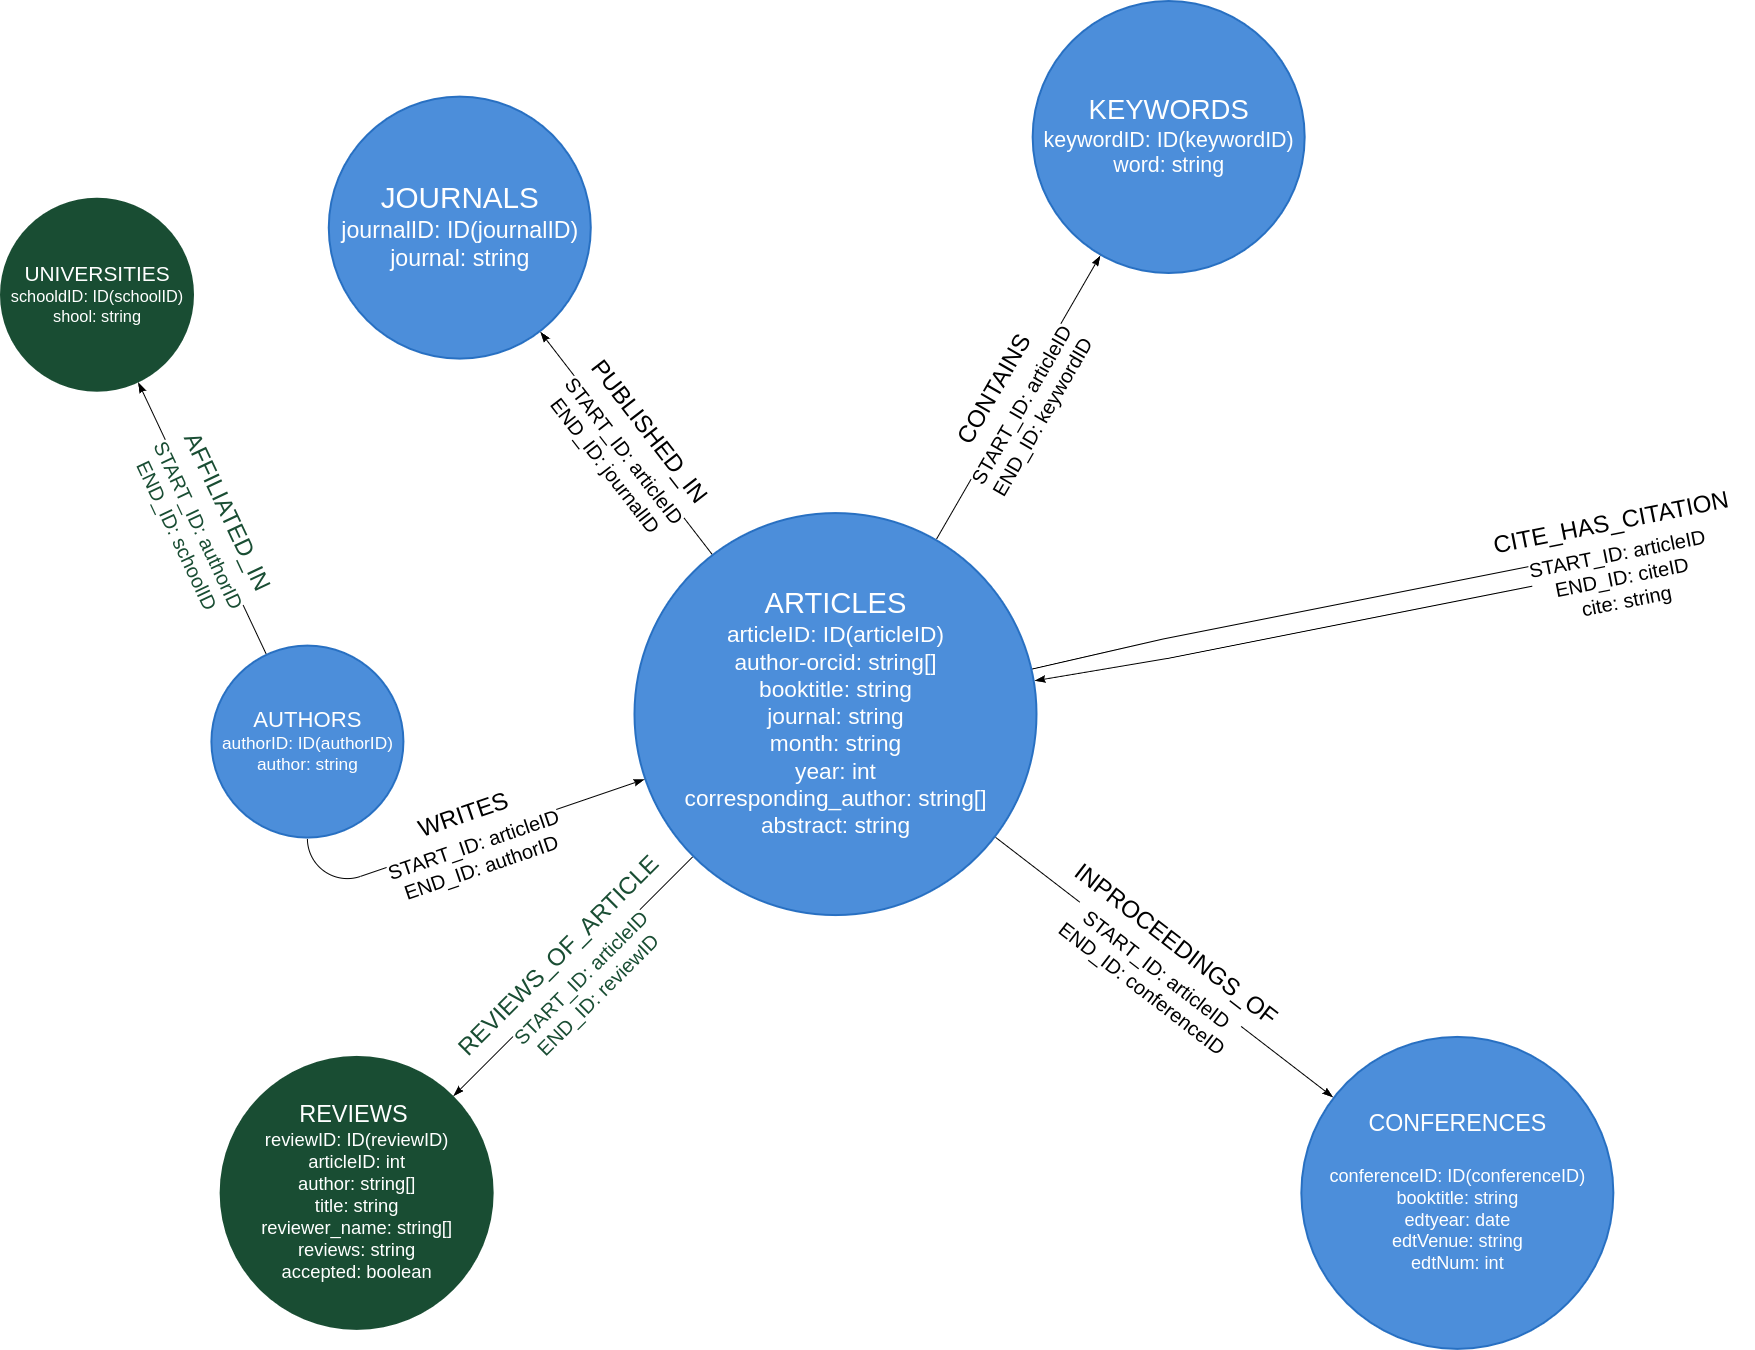

In [4]:
# Image showing Evolved graph
Image('Mains/evolved-graph.png',  width=600, height=600)

#### PRE-PROCESSING DBLP DATA

##### (:CITE NODE) --> [:CITE_HAS_CITATION]

In [5]:
# Read all data from articles 

## Article headers
with open('DXML\\output_article_header.csv') as f:
    article_header = f.readline().split(';');
    #print(article_header[1:5])

## Articles in dataset
articles = pd.read_csv('DXML\\output_article.csv', header=0, names=article_header, sep=';');

## Display articles
articles.head(1)

,article:ID,author:string[],author-aux:string,author-orcid:string[],booktitle:string,cdate:date,cdrom:string,cite:string[],cite-label:string[],crossref:string,...,publnr:string,publtype:string,sub:string[],sup:string[],title:string,title-bibtex:string,tt:string[],url:string[],volume:string,year:int
0,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,informal,NaN,NaN,…,NaN,NaN,NaN,NaN,NaN


In [6]:
# Selecting only 10000 articles
art_sel = articles[:10000]

In [7]:
# Split the articles into Journals, Conferences, Workshops or None of thw above
## we assume all papers are accepted but with a ditribution of 95% for True (accepted)
art_sel['sup:string[]'] = np.random.choice(['J', 'C', 'W', 'N'], size=len(art_sel), p=[0.35, 0.45, 0.12, 0.08])

In [8]:
# Split for cite and citation
# split the dataframe into two parts i.e 0.33% for cite
art_citation, art_cite = train_test_split(art_sel, test_size=0.33, random_state=42)

In [9]:
# Ensure articles in citation are written before cite articles

## create a list of year values to assign randomly from 2017-2019
values = [2017, 2018, 2019]

## randomly assign the values as a new column in the DataFrame
art_citation['year:int'] = np.random.RandomState(42).choice(values, len(art_citation))

#art_citation.head(1)

In [10]:
# Ensure articles in cite are written after citation articles

# create a list of values to assign randomly from 2021-2022
values = [2020, 2021, 2022]

# randomly assign the values as a new column in the DataFrame
art_cite['year:int'] = np.random.RandomState(42).choice(values, len(art_cite))

#art_cite.head(1)

In [11]:
# Creating the edge cite has citation

## Selecting citation
cite_cita = art_citation[['author-aux:string', 'article:ID']]

## Replicate the citation df so that each article has at least 2 citations
cite_cita = pd.concat([cite_cita]*2, ignore_index=True)

In [12]:
## randomly assign cite articles to citation

# obtain set list of cite
ref_in_art_cite = list(set(list(art_cite['article:ID'])))

# Define function to randomly assignIDs
def assign_no():
    return random.choice(ref_in_art_cite)

# Apply function to create edition venue column with randomly assigned cities
cite_cita['author-aux:string'] = cite_cita.apply(lambda x: assign_no(), axis=1)

In [13]:
# Rename columns to match Neo4j requirememts
cite_cita = cite_cita.rename(columns={'author-aux:string': 'articleid',
                                     'article:ID': 'citaid'})

cite_cita.drop_duplicates(subset=['articleid','citaid'], inplace=True)

In [14]:
# Save to CSV
cite_cita.to_csv(path_or_buf='Mains/cite_has_citation.csv', index=False, header=True)


In [15]:
# Free Memory
del art_sel, articles
gc.collect()

0

##### (:ARTICLE NODE)

In [16]:
## Articles selected
articles_selected = pd.concat([art_citation, art_cite])

ref_in_cite = list(set(list(articles_selected['article:ID'])))
print(f'The total papers are: {len((ref_in_cite))}')

The total papers are: 10000


In [17]:
## Ensure all articles are from 2018 to 2022
unique_years = articles_selected['year:int'].unique()

print(unique_years)

[2019 2017 2018 2022 2020 2021]


In [18]:
# free up Memory Allocation

gc.collect()

0

##### (:AUTHORS NODE) --> [:AUTHORS_WRITES_ARTICLES]

In [19]:
# Read all data from Authors

## authors
authors = pd.read_csv('DXML\\output_author.csv',sep=';')

## authors writes articles
authors_articles = pd.read_csv('DXML\\output_author_authored_by.csv', sep=';')

In [20]:
authors.head()
#authors.shape


,:ID,author:string
0,9734485,Oliver Hoffmann 0002
1,9734486,Florian Reitz
2,9734487,Russell Turpin
3,9734488,Frank Olken
4,9734489,Guido Frisch


In [21]:
## Replicate the articles to have atleast 4 different articles with different authors

aser = pd.concat([articles_selected[['article:ID', 'author-aux:string']]]*4, ignore_index=True)

In [22]:
aser.shape

(40000, 2)

In [23]:
# Selecting 1000 authors
## Assign to 10000 selected articles to have atleast 4 writers per article type

aut_sel = authors[1000:2000]
len(aut_sel)

1000

In [24]:
## Assign the authors list randomly to articles

aut_sel_id = list(set(list(aut_sel[':ID'])))

# Define function to randomly assignIDs
def assign_no():
    return random.choice(aut_sel_id)

# Apply function to create edition venue column with randomly assigned cities
aser['author-aux:string'] = aser.apply(lambda x: assign_no(), axis=1)


In [25]:
##merge to get author names
authors_in_articles_sel = pd.merge(aut_sel, aser, left_on=':ID', right_on='author-aux:string')

In [26]:
## drop duplicates
authors_in_articles_sel= authors_in_articles_sel.drop_duplicates(subset=[':ID', 'article:ID'])
authors_in_articles_sel.head()



,:ID,author:string,article:ID,author-aux:string
0,9735485,Sumit Ganguly,6614829,9735485
1,9735485,Sumit Ganguly,6612305,9735485
2,9735485,Sumit Ganguly,6616712,9735485
3,9735485,Sumit Ganguly,6614665,9735485
4,9735485,Sumit Ganguly,6620184,9735485


In [27]:
# Creating replica
authors_in_articles_sel1 = authors_in_articles_sel.copy()
authors_in_articles_sel.shape

(39936, 4)

In [28]:
## convert to str type and rename
authors_in_articles_sel['article:IDstr[]'] = authors_in_articles_sel['article:ID'].astype(str)

In [29]:
# create sample dataframe

# group by 'group' column and aggregate values with "|"
merge_auth = authors_in_articles_sel.groupby('article:IDstr[]')['author:string'].agg('|'.join).reset_index()

# print resulting dataframe
merge_auth.head(2)

,article:IDstr[],author:string
0,4038748,Tomoya Mori|Md-Mizanur Rahoman|Björn Hammarberg|Fredrik Espinoza
1,4039839,Gustavo Castellano|Ilmiawan Shubhi|Kanae Akaiwa|Tobias Olsson


In [30]:
# change ID to int type
merge_auth['article:IDstr[]'] = merge_auth['article:IDstr[]'].astype(int)

In [31]:
#Add info to articles_selected for articles
articles_selected1 = pd.merge(merge_auth, articles_selected, left_on='article:IDstr[]', 
                                   right_on='article:ID').drop(columns = [i for i in merge_auth.columns])

In [32]:
# creating replics
articles_selected = articles_selected1.copy()

In [33]:
## Rename columns to match Neo4j requirememts

authors_in_articles_sel1 = authors_in_articles_sel1[[':ID', 'article:ID']]
authors_in_articles_sel1 = authors_in_articles_sel1.rename(columns={':ID': 'authorid', 'article:ID': 'articleid'})

authored_with_articles1 = authors_in_articles_sel.copy()
authored_with_articles1.rename(columns={':ID': 'authorID'}, inplace=True)
authored_with_articles1.drop(columns = ['article:ID','author-aux:string','article:IDstr[]' ], inplace=True)
authored_with_articles1.drop_duplicates(subset=['authorID'], inplace=True)

In [34]:
# Save to CSV

## authors writes articles
authors_in_articles_sel1.to_csv(path_or_buf='Mains/authors_writes_articles.csv', index=False, header=True)

## authors
authored_with_articles1.to_csv(path_or_buf='Mains/authors.csv', index=False, header=True)

In [35]:
## Free memory
del authors, authors_articles
gc.collect()

0

##### (:JOURNALS NODE) --> [:PUBLISHED_IN]

In [36]:
# Read all data from Journals

## Journals
journals = pd.read_csv('DXML\\output_journal.csv',sep=';')

## Journals published
#articles_in_journals = pd.read_csv('DXML\\output_journal_published_in.csv',sep=';')

In [37]:
## fetch journals from article list J
fil_journal = articles_selected.loc[articles_selected['sup:string[]'] == 'J']

print(f'The total journals are: {(fil_journal.shape[0])}')

The total journals are: 3508


In [38]:
fil_journal1 = fil_journal[['article:ID','crossref:string', 'volume:string']]

In [39]:
## Selecting 8 journals for use
journals = journals[12:20]

#journals.shape

In [40]:
# Similarly like the cite node, assign selected journals to edge

ref_in_journal = list(set(list(journals[':ID'])))

# Define function to randomly assign city
def assign_no():
    return random.choice(ref_in_journal)

# Apply function to create edition venue column with randomly assigned cities
fil_journal1['crossref:string'] = fil_journal1.apply(lambda x: assign_no(), axis=1)

In [41]:
## Rename columns to match Neo4j requirememts
fil_journal1 = fil_journal1.rename(columns={'article:ID': 'articleid',
                                     'crossref:string': 'journalid'})
fil_journal1.drop_duplicates(subset=['articleid'], inplace=True)

merged_journals1 = journals.copy()
merged_journals1.rename(columns={':ID': 'journalID'}, inplace=True)

merged_journals1.drop_duplicates(subset=['journalID'], inplace=True)

In [42]:
# Save to CSV

## articles published in journals
fil_journal1.to_csv(path_or_buf='Mains/articles_in_journal.csv', index=False, header=True)

## journals
merged_journals1.to_csv(path_or_buf='Mains/journals.csv', index=False, header=True)


In [43]:
del journals
gc.collect()

0

##### (:CONFERENCES NODE) --> [:INPROCEEDINGS_OF]

In [44]:
# Read all inproceedings 

## Article headers
with open('DXML\\output_inproceedings_header.csv') as f:
    proceedings_header = f.readline().split(';');
    #print(proceedings_header[1:5])

## Number of articles in dataset
inproceedings = pd.read_csv('DXML\\output_inproceedings.csv', header=0, names=proceedings_header, sep=';');

## Display articles
#inproceedings.head(2)

In [45]:
# Pre-processing Total number of inproceedings

## Drop inproceedings columns with more than half null values 
inproceedings.drop(columns = [i for i in inproceedings.columns if (inproceedings[i].isna().sum() > inproceedings[i].count()/2) == True], inplace = True)

## Drop inproceedings rows without author, number or articleID
inproceedings.dropna(subset = [i for i in inproceedings.columns], inplace = True)

In [46]:
## fetch journals from article list
fil_conf = articles_selected.loc[articles_selected['sup:string[]'] == 'C']

In [47]:
# Similarly like the cite node, assign selected conferences to edge

fil_conf = list(set(list(fil_conf['article:ID'])))

# Define function to randomly assign
def assign_no():
    return random.choice(fil_conf)

# Apply function to create edition venue column with randomly assigned cities
inproceedings[':START_ID'] = inproceedings.apply(lambda x: assign_no(), axis=1)

In [48]:
## Assign edition numbers

Conf_no = ['9999|ECIS|European Conference on Information Systems (ECIS)',
           '8888|ECSW|European Conference on Computer-Supported Cooperative Work (ECSCW)',
           '7777|ECHI|European Conference on Human-Computer Interaction (ECHI)',
           '6666|ECIR|European Conference on Information Retrieval (ECIR)',
           '5555|ECAI|European Conference on Artificial Intelligence (ECAI)',
           '4444|IEEE|International Conference on Data Mining (ICDM)',
           '3333|ICML|International Conference on Machine Learning (ICML)',
           '2222|IJCAI|International Joint Conference on Artificial Intelligence (IJCAI)']



# Define function to randomly assign city
def assign_no():
    return random.choice(Conf_no)

# Apply function to create edition venue column with randomly assigned cities
inproceedings['Conf_no'] = inproceedings.apply(lambda x: assign_no(), axis=1)


inproceedings[['inproceedings:ID','Conf:string', 'ConfName:string']] = inproceedings['Conf_no'].str.split("|", expand = True)



In [49]:
# remove duplicates
inproceedings.drop_duplicates(subset=[':START_ID'], inplace=True)

# make copies for edge
articles_sel_in_inproceedings = inproceedings.copy()

## copy articles in node
sel_inproceedings = articles_sel_in_inproceedings.copy()

In [50]:
## drop unneccesary columns for edge
drop_col = ['author:string[]', 'booktitle:string', 'crossref:string[]', 
            'ee:string[]', 'key:string', 'mdate:date','pages:string', 
            'title:string', 'url:string', 'year:int',]

sel_inproceedings.drop(columns=drop_col, inplace = True)

In [51]:
## drop unneccesary
drop_col = ['year:int', ':START_ID']

articles_sel_in_inproceedings.drop(columns=drop_col, inplace = True)

In [52]:
## Assign edition numbers

editions_no = ['Barcelona|1', 'Brussels|2', 'Milan|3', 'Amsterdam|4']



# Define function to randomly assign city
def assign_no():
    return random.choice(editions_no)

# Apply function to create edition venue column with randomly assigned cities
articles_sel_in_inproceedings['edt'] = articles_sel_in_inproceedings.apply(lambda x: assign_no(), axis=1)


articles_sel_in_inproceedings[['edtVen:string', 'edtNum:int']] = articles_sel_in_inproceedings['edt'].str.split("|", expand = True)



In [53]:
## Rename columns to match Neo4j requirememts

sel_inproceedings1 = sel_inproceedings.copy().rename(
    columns={':START_ID': 'articleid', 'inproceedings:ID': 'conferenceid'})

sel_inproceedings1 = sel_inproceedings1[['articleid', 'conferenceid']]
sel_inproceedings1.drop_duplicates(subset=['articleid'], inplace=True)


articles_sel_in_inproceedings1 = articles_sel_in_inproceedings.copy()
articles_sel_in_inproceedings1.rename(columns={'inproceedings:ID':'conferenceID',
                                               'mdate:date':'edtyear:date', 'booktitle:string': 'edtTitle:string'}, inplace=True)
articles_sel_in_inproceedings1.drop(columns = ['author:string[]', 'edt', 'Conf_no'], inplace=True)
articles_sel_in_inproceedings1.drop_duplicates(subset=['conferenceID'], inplace=True)

In [54]:
articles_sel_in_inproceedings1.head(1)

,conferenceID,edtTitle:string,crossref:string[],ee:string[],key:string,edtyear:date,pages:string,title:string,url:string,Conf:string,ConfName:string,edtVen:string,edtNum:int
0,4444,CoopIS,conf/coopis/2000,https://doi.org/10.1007/10722620_29,conf/coopis/ChenD00,2017-05-24,311-322,Multi-Agent Cooperative Transactions for E-Commerce.,db/conf/coopis/coopis2000.html#ChenD00,IEEE,International Conference on Data Mining (ICDM),Brussels,2


In [55]:
## Save to CSV

# articles_inproceedings_conferences
sel_inproceedings1.to_csv(path_or_buf='Mains/articles_in_conferences.csv', index=False, header=True)

# conferences
articles_sel_in_inproceedings1.to_csv(path_or_buf='Mains/conferences.csv',index=False, header=True)

In [56]:
del inproceedings
gc.collect()

35

##### (:REVIEWERS NODE) --> [:REVIEWS]

In [57]:
## articles for reviews 
art_rev_selected = articles_selected[['article:ID', 'author:string[]', 'title:string']]

In [58]:
# Creating list of reviewers

split_authors = art_rev_selected['author:string[]'].str.split("|", expand=True)

authors_list = []

for i in split_authors[split_authors.columns[0]].values.tolist():
    authors_list.append(i)
        
my_auth_list = list(set(list(authors_list)))
print(my_auth_list[4:8])

['Elias Koutsoupias', 'Choon Yik Tang', 'Joseph E. Stoy', 'Charika De Alvis']


In [59]:
# remove nan from first column
my_auth_list = my_auth_list[1:]

In [60]:
## Duplicate art_rev_selected thrice because we assume that every articles must have at least 3 reviews
art_rev_selected = pd.concat([art_rev_selected]*3, ignore_index=True)

In [61]:
## Assigning authors list to reviews
random.seed(42)

# define list of values to randomly assign
my_list = my_auth_list

# define function to randomly assign value from list to new column, avoiding strings
def assign_value(row, my_list):
    new_value = random.choice(my_list)
    while any([str(new_value) in str(x) for x in row.values]):
        new_value = random.choice(my_list)
    return new_value

# set random seed for reproducibility
random.seed(42)

# apply function to create new column with randomly assigned values
art_rev_selected['reviewer_name:string[]'] = art_rev_selected.apply(lambda row: assign_value(row, my_list), axis=1)

# print resulting dataframe
art_rev_selected.head(1)

,article:ID,author:string[],title:string,reviewer_name:string[]
0,4038748,Clement T. Yu|Hai He|Weiyi Meng|Yiyao Lu|Zonghuan Wu,Towards Deeper Understanding of the Search Interfaces of the Deep Web.,Alvis Brazma


In [62]:
## confirm it was well assigned
filtered_df = art_rev_selected.loc[art_rev_selected['article:ID'] == 6667990]
filtered_df

,article:ID,author:string[],title:string,reviewer_name:string[]


In [63]:
# Create reviews using Lorem library
review_comm = []

for i in range(art_rev_selected.shape[0]):
    review_comm.append(lorem.sentence())
        
art_rev_selected['reviews:string'] = review_comm

In [64]:
# Assigning IDs to eachh reviews
art_rev_selected['reviewID:ID(reviewID)'] = range(999, len(art_rev_selected)+999)

In [65]:
# ensure that if majority of the papers are accepted then it is published.
## we assume all papers are accepted but with a ditribution of 95% for True (accepted)
art_rev_selected['accepted:boolean'] = np.random.choice([True, False], size=len(art_rev_selected), p=[0.95, 0.05])

In [66]:
## Rename columns to match Neo4j requirememts

art_rev_selected['article:ID'] = art_rev_selected['article:ID'].astype(int)

article_in_reviews = art_rev_selected[['article:ID', 'reviewID:ID(reviewID)']]

article_in_reviews = article_in_reviews.rename(
    columns={'article:ID': 'articleid', 'reviewID:ID(reviewID)': 'reviewid'})

reviews = art_rev_selected[['reviewID:ID(reviewID)', 'article:ID', 'author:string[]', 'title:string',
                            'reviewer_name:string[]', 'reviews:string', 'accepted:boolean']]
reviews.rename(columns={'reviewID:ID(reviewID)':'reviewID' ,'article:ID': 'articleID:int'}, inplace=True)
reviews.drop_duplicates(subset=['reviewID'], inplace=True)

In [67]:
## Save to CSV
article_in_reviews.to_csv(path_or_buf='Mains/reviews_in_articles.csv', index=False, header=True)

reviews.to_csv(path_or_buf='Mains/reviews.csv', index=False, header=True)

In [68]:
del art_rev_selected
gc.collect()

17

##### {ADDING ABSTRACTS TO ARTICLES & CORRESPONDING AUTHOR}

In [69]:
## Generating abstracts using Lorem library
abstracts = []

for i in range(articles_selected.shape[0]):
    abstracts.append(lorem.paragraph())
        
articles_selected['abstract:string'] = abstracts

In [70]:
# Adding titles to Abstracts so that it contains good keywords

articles_selected['title:string'] = articles_selected['title:string'].astype(str)
articles_selected['abstract:string'] = articles_selected[['abstract:string', 'title:string']].agg(' '.join, axis=1)
articles_selected["corresponding_author:string"] = articles_selected["author:string[]"].str.split("|", expand = True)[0]

In [71]:
articles_selected.columns

Index(['article:ID', 'author:string[]', 'author-aux:string',
       'author-orcid:string[]', 'booktitle:string', 'cdate:date',
       'cdrom:string', 'cite:string[]', 'cite-label:string[]',
       'crossref:string', 'editor:string[]', 'editor-orcid:string[]',
       'ee:string[]', 'ee-type:string[]', 'i:string[]', 'journal:string',
       'key:string', 'mdate:date', 'month:string', 'note:string[]',
       'note-label:string', 'note-type:string[]', 'number:string',
       'pages:string', 'publisher:string', 'publnr:string', 'publtype:string',
       'sub:string[]', 'sup:string[]', 'title:string', 'title-bibtex:string',
       'tt:string[]', 'url:string[]', 'volume:string', 'year:int',
       'abstract:string', 'corresponding_author:string'],
      dtype='object')

In [72]:
#Instance for citation
articles_insta = articles_selected[['article:ID','author:string[]', 'title:string', 'year:int']]

articles_insta.rename(columns={'article:ID':'citaID'}, inplace=True)


In [73]:
## Rename columns to match Neo4j requirememts
articles_selected.rename(columns={'article:ID':'articleID','mdate:date':'edtyear:string[]','sup:string[]':'sup' }, inplace=True)

articles_selected.dropna(axis=1, how='all', inplace=True)

articles_selected.drop_duplicates(subset=['articleID'], inplace=True)

articles_selected['year:int'] = articles_selected['year:int'].astype(int)



In [74]:
# Save to CSV

## Articles instances 
articles_selected.to_csv(path_or_buf='Mains/articles.csv', index=False, header=True)

#citation
articles_insta.to_csv(path_or_buf='Mains/citation.csv', index=False, header=True)

##### (:KEYWORDS NODE) --> [:CONTAINS]

In [75]:
# Generate KEYWORDS from titles/abstract of articles to add for the community

split_title = articles_selected["title:string"].str.split(" ", expand=True)

kwords = []

## words with lenght 15
for i in split_title[split_title.columns[0]].values.tolist():
    if len(i)==15:
        kwords.append(i)
        
my_list = list(set(list(kwords)))

In [76]:
# Filter out words containing non-ASCII characters
my_list = [word for word in my_list if all(ord(char) < 128 for char in word)]

print(my_list[4:8])


['Proxy-invisible', 'Label-Selective', 'Query-monotonic', 'Polynomial-Time']


In [77]:
# Adding more keywords from exercises so that least 90% is contained from this 
db_keywords = ['data management', 'indexing', 'data modeling', 'big data', 'data processing',
               'data storage', 'data querying']

# Combine list 
combined_list = db_keywords + my_list

In [78]:
# create new column with randomly assigned values
def assign_value():
    if random.random() < 0.95:
        return random.choice(db_keywords)
    else:
        return random.choice(my_list)

aser['author-aux:string'] = aser.apply(lambda x: assign_value(), axis=1)

In [79]:
# Create DataFrame for kwords and add ID column 
kword = pd.DataFrame(combined_list, columns=['word:string'])
kword = kword.reset_index(drop=False)
kword['keywordID:ID(keywordID)'] = kword.index + 999

# Print resulting DataFrame
len(kword)

117

In [80]:
##merge to obtain articles

aser_sel = pd.merge(kword, aser, left_on='word:string', right_on='author-aux:string')

In [81]:
## Rename columns to match Neo4j requirememts
aser = aser_sel[['article:ID','keywordID:ID(keywordID)']]
aser.rename(columns={'article:ID': 'articleid', 'keywordID:ID(keywordID)': 'keywordid'},inplace=True)
aser.drop_duplicates(subset=['articleid','keywordid'], inplace=True)

keywords = kword[['keywordID:ID(keywordID)','word:string']]
keywords.rename(columns={'keywordID:ID(keywordID)': 'keywordID'},inplace=True)
keywords.drop_duplicates(subset=['keywordID'], inplace=True)

In [82]:
# Save to CSV
## keywords
keywords.to_csv(path_or_buf='Mains\\keywords.csv', index=False, header=True)

## articles with keywords
aser.to_csv(path_or_buf='Mains\\article_keywords.csv', index=False, header=True)

In [83]:
#del article_keywords, keywords
gc.collect()


16

##### (:UNIVERSITIES NODE) --> [:AFFILIATED_IN]

In [84]:
# Read all dataset from school

## Universities
school = pd.read_csv('DXML\\output_school.csv',sep=';')

## Affiliates
output_school_submitted_at = pd.read_csv('DXML\\output_school_submitted_at.csv',sep=';')

In [85]:
## Randomly assign authors to a schools
## Assuming the authors are affiliated to only schools all across the world

random.seed(42)


# define list of values to randomly assign
my_list = list(set(list(authors_in_articles_sel1['authorid'])))


# define function to randomly assign value from list to new column, avoiding repition
def assign_value(row, my_list):
    new_value = random.choice(my_list)
    while any([str(new_value) in str(x) for x in row.values]):
        new_value = random.choice(my_list)
    return new_value

# set random seed for reproducibility
random.seed(42)

# apply function to create new column with randomly assigned values
output_school_submitted_at[':START_ID(authorID)'] = output_school_submitted_at.apply(lambda row: assign_value(row, my_list), axis=1)


In [86]:
# merge wtih affiliated
output_school_submitted_at = output_school_submitted_at[[':START_ID(authorID)',':END_ID']].rename(columns={':START_ID(authorID)':'authorid', ':END_ID': 'schoolid'})

In [87]:
# ## Rename columns to match Neo4j requirememts

school.rename(columns={':ID': 'schoolID'}, inplace=True)

school.drop_duplicates(subset=['schoolID'], inplace=True)

In [88]:
# Save as CSV

## author_affiliated_school
output_school_submitted_at.to_csv(path_or_buf='Mains/author_affiliated_school.csv', index=False, header=True)

## Universities
school.to_csv(path_or_buf='Mains/school.csv', index=False, header=True)

In [89]:
del output_school_submitted_at, school
gc.collect()

0

#### Generated CSV files

In [90]:
#All CSV files generated from after pre-processing
## All files and directories ending with .csv:
files = (glob.glob("Mains/*.csv"))

#Generated files names
files

['Mains\\articles.csv',
 'Mains\\articles_in_conferences.csv',
 'Mains\\articles_in_journal.csv',
 'Mains\\article_keywords.csv',
 'Mains\\authors.csv',
 'Mains\\authors_writes_articles.csv',
 'Mains\\author_affiliated_school.csv',
 'Mains\\citation.csv',
 'Mains\\cite_has_citation.csv',
 'Mains\\conferences.csv',
 'Mains\\journals.csv',
 'Mains\\keywords.csv',
 'Mains\\reviews.csv',
 'Mains\\reviews_in_articles.csv',
 'Mains\\school.csv']